<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 4: Web Scraping Job Postings

Detailed instructions are in Readme.md 
My answers for this Project are split into several notebooks to make it easier to review key sections and make changes where needed. In 1.1, I work on cleaning the jobs data.

# NOTE: 
I have less than 1,000 listings. But most of the data, taken from a Government website, has the salary range, which is critical to the analysis. I have also used 20 different search items while scrapping for the listings and don't think it is wise to blindly broaden the search parameters further for the sake of fulfilling the the 1,000 listings criteria.

In [1]:
%load_ext blackcellmagic

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

mpl.rcParams["figure.dpi"] = 300
%matplotlib inline
%config InlineBackend.figure_format ='retina'

### 1. CLEANING OF NUMERIC JOBS/SALARY DATA

In [3]:
jobs = pd.read_csv('../data/jobs.csv')

In [4]:
jobs = jobs.drop(columns = 'Unnamed: 0')

In [5]:
jobs.head()

,Company,Title,Salary_Range,Responsibilities,Requirements,Seniority,Employment_Type,Category,Address
0,HITACHI CONSULTING SINGAPORE PTE. LTD.,Senior Consultant (Data Scientist),"$6,000to$9,000",Roles & Responsibilities Problem solver with c...,Requirements Sound knowledge of machine learni...,Senior Executive,"Permanent, Contract",Information Technology,"PLAZA 8 @ CBP, 1 CHANGI BUSINESS PARK CRESCENT..."
1,TRAVELOKA SERVICES PTE. LTD.,Data Science Lead,"$10,000to$15,000","Roles & ResponsibilitiesAs a Data scientist, y...",RequirementsWe are looking for someone with: ...,Manager,Full Time,Information Technology,NaN
2,TRAVELOKA SERVICES PTE. LTD.,Senior Level Data Scientist,"$8,300to$15,000",Roles & ResponsibilitiesJob Description As a D...,Requirements Solid programming skills and und...,Executive,Permanent,Information Technology,NaN
3,TRAVELOKA SERVICES PTE. LTD.,Mid - Senior Level Data Scientist,"$6,100to$10,700","Roles & ResponsibilitiesAs a Data scientist, y...",Requirements Solid programming skills and und...,Executive,Permanent,Information Technology,NaN
4,TRAVELOKA SERVICES PTE. LTD.,Mid Level Data Scientist,"$4,300to$7,600","Roles & ResponsibilitiesAs a Data scientist, y...",Requirements Solid programming skills and und...,Executive,Permanent,Information Technology,NaN


#### On inspection, it appears 42 rows are completely empty due to dead links. Let's drop those.

In [6]:
jobs = jobs.dropna(axis=0, how='all')

In [7]:
# Dropping duplicates not picked up in the first round after web-scrapping 
jobs = jobs.drop_duplicates(keep=False)

In [8]:
# At a later stage, I discovered that several more duplicates from A*Star and DBS escaped detection
# It makes better sense to remove them at this stage then later

jobs = jobs.drop([76, 295, 324, 325, 327, 423, 428, 429, 430, 463, 768, 769, 770])

In [9]:
jobs.shape

(847, 9)

In [10]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 847 entries, 0 to 973
Data columns (total 9 columns):
Company             847 non-null object
Title               847 non-null object
Salary_Range        795 non-null object
Responsibilities    847 non-null object
Requirements        847 non-null object
Seniority           847 non-null object
Employment_Type     847 non-null object
Category            847 non-null object
Address             667 non-null object
dtypes: object(9)
memory usage: 66.2+ KB


In [11]:
jobs.isnull().sum()

Company               0
Title                 0
Salary_Range         52
Responsibilities      0
Requirements          0
Seniority             0
Employment_Type       0
Category              0
Address             180
dtype: int64

In [12]:
# Replacing the missing addresses with "Undisclosed"
jobs['Address'] = jobs['Address'].fillna('Undisclosed')

#### 1.1 MINOR FEATURE ENGINGEERING TO SPLIT SALARY INTO LOW AND HIGH RANGE

In [13]:
salary_high_low = jobs['Salary_Range'].str.split('to', 1, expand=True)

In [14]:
salary_high_low.columns = ['Salary_Min', 'Salary_Max']

In [15]:
jobs = pd.concat([jobs, salary_high_low], axis = 'columns')

In [16]:
jobs = jobs.drop(columns = 'Salary_Range')

In [17]:
# Removing $ and comma from the salary columns
jobs['Salary_Min'] = jobs['Salary_Min'].map(lambda x : str(x).replace('$',''))
jobs['Salary_Max'] = jobs['Salary_Max'].map(lambda x : str(x).replace('$',''))
jobs['Salary_Min'] = jobs['Salary_Min'].map(lambda x : str(x).replace(',',''))
jobs['Salary_Max'] = jobs['Salary_Max'].map(lambda x : str(x).replace(',',''))

In [18]:
# Converting salary cols to numeric dtype
jobs['Salary_Min'] = pd.to_numeric(jobs['Salary_Min'], errors='coerce')
jobs['Salary_Max'] = pd.to_numeric(jobs['Salary_Max'], errors='coerce')

#### 1.2 ADJUSTING SOME SALARY FIGURES AND IMPUTING MISSING SALARIES

In [19]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 847 entries, 0 to 973
Data columns (total 10 columns):
Company             847 non-null object
Title               847 non-null object
Responsibilities    847 non-null object
Requirements        847 non-null object
Seniority           847 non-null object
Employment_Type     847 non-null object
Category            847 non-null object
Address             847 non-null object
Salary_Min          795 non-null float64
Salary_Max          795 non-null float64
dtypes: float64(2), object(8)
memory usage: 72.8+ KB


In [20]:
jobs.describe()

,Salary_Min,Salary_Max
count,795.000000,795.000000
mean,9948.943396,15436.026415
std,25845.386817,35828.760280
min,1800.000000,2000.000000
25%,4000.000000,6000.000000
50%,5000.000000,8000.000000
75%,7500.000000,12000.000000
max,380000.000000,405000.000000


#### It's clear from the table above there are some unusual salary numbers in the mix. AspenTech, for instance, is offering a salary of SGD380,000 to SGD405,000. A check on the jobs portal shows that the figure is indeed an annual renumeration [https://www.mycareersfuture.sg/job/vp-sales-aspentech-dbe12dc833aac79f3ccccb02c491b983]

#### Further checks show that these companies are using annual renumeration, which would have to be changed to monthly renumeration:
- DataRobot
- ONECONNECT FINANCIAL TECHNOLOGY 
- CISCO SYSTEMS
- MICROSOFT OPERATIONS
- RECORDED FUTURE PTE. LTD
- SYNECHRON TECHNOLOGIES SINGAPORE PTE. LTD
- AUTODESK ASIA
- HILTON INTERNATIONAL ASIA PACIFIC PTE LTD
- BEATHCHAPMAN (PTE. LTD.)
- PURE STORAGE SINGAPORE PTE. LIMITED
- FIREVISOR SYSTEMS PTE. LTD.
- FOURTH PARADIGM SOUTHEAST ASIA PTE. LTD
- NATIONAL UNIVERSITY OF SINGAPORE
- ASPENTECH PTE. LTD
- S.W.I.F.T. TERMINAL SERVICES PTE. LTD.
- UNDERWRITEME TECHNOLOGY SOLUTIONS LIMITED SINGAPORE BRANCH
- MERCER HEALTH & BENEFITS (SINGAPORE) PTE. LTD
- VISA WORLDWIDE PTE. LIMITED
- SABRE ASIA PACIFIC PTE. LTD
- Company Undisclosed (one entry)

In [21]:
#As suspected, companies offering "minimum" salary of 30,000 dollars were giving annual renumeration
jobs[jobs['Salary_Min'] > 30000]

,Company,Title,Responsibilities,Requirements,Seniority,Employment_Type,Category,Address,Salary_Min,Salary_Max
11,DATAROBOT SINGAPORE PTE. LTD.,Applied Data Science Associate,Roles & ResponsibilitiesLooking to move into D...,RequirementsMain Requirements Experience/Trai...,Professional,Permanent,Information Technology,80 ROBINSON ROAD 068898,90000.0,150000.0
19,DATAROBOT SINGAPORE PTE. LTD.,"Data Scientist, AI Services",Roles & ResponsibilitiesAI Services is a consu...,RequirementsMain Requirements * 3+ years of re...,Professional,Permanent,Information Technology,80 ROBINSON ROAD 068898,90000.0,150000.0
33,ONECONNECT FINANCIAL TECHNOLOGY (SINGAPORE) CO...,Intelligent Risk Data Scientist Manager / Assi...,"Roles & Responsibilities Develop AI Algorithm,...",Requirements More than 5 years (10 years for S...,Senior Executive,"Permanent, Full Time",Information Technology,Undisclosed,96000.0,120000.0
67,CISCO SYSTEMS (USA) PTE. LTD.,Senior Data Scientist,Roles & Responsibilities What You'll Do As ...,RequirementsWho You Are Do you thrive in a mul...,Professional,Full Time,Information Technology,"ONE MARINA BOULEVARD, 1 MARINA BOULEVARD 018989",170000.0,230000.0
104,DATAROBOT SINGAPORE PTE. LTD.,Business Intelligence Analyst - Machine Engine...,Roles & ResponsibilitiesWe are building a comp...,RequirementsRequirements 3+ years of experien...,Professional,Permanent,Information Technology,80 ROBINSON ROAD 068898,90000.0,150000.0
106,DATAROBOT SINGAPORE PTE. LTD.,Senior Backend Engineer,Roles & ResponsibilitiesDataRobot accelerates ...,RequirementsMain Requirements: 3+ years devel...,Professional,Permanent,Information Technology,80 ROBINSON ROAD 068898,90000.0,150000.0
108,DATAROBOT SINGAPORE PTE. LTD.,Quality Engineer,Roles & ResponsibilitiesDataRobot changes the ...,Requirements 3+ years of professional quality ...,Professional,Permanent,Information Technology,80 ROBINSON ROAD 068898,90000.0,150000.0
148,MICROSOFT OPERATIONS PTE LTD,Business Program Manager,Roles & ResponsibilitiesMicrosoft’s HIT team e...,RequirementsQualifications Behaviour and cha...,Non-executive,Full Time,Information Technology,Undisclosed,90000.0,135000.0
149,RECORDED FUTURE PTE. LTD.,"Director of Sales Engineering, APJ",Roles & ResponsibilitiesWant to be part of sha...,RequirementsQualifications Minimum of 3-5 yea...,Senior Management,Full Time,Information Technology,Undisclosed,180000.0,190000.0
157,DATAROBOT SINGAPORE PTE. LTD.,Software Engineer in Test,Roles & ResponsibilitiesThis position’s respon...,RequirementsSkills: Solid foundation in quali...,Professional,Permanent,Information Technology,80 ROBINSON ROAD 068898,100000.0,120000.0


In [22]:
# Converting min salaries from annual renumeration to monthly figures
jobs['Salary_Min'] = jobs.apply(lambda row: row['Salary_Min']/12
                                if row['Salary_Min'] > 30000
                                else row['Salary_Min'],
                                axis= 1)

In [23]:
# Converting max salaries from annual renumeration to monthly figures
jobs['Salary_Max'] = jobs.apply(lambda row: row['Salary_Max']/12
                                if row['Salary_Max'] > 30000
                                else row['Salary_Max'],
                                axis= 1)

In [24]:
# Creating an average salary column for easier comparison during modelling 
jobs['Salary_Average'] = (jobs['Salary_Min'] + jobs['Salary_Max'])/2
jobs['Salary_Average'] = jobs['Salary_Average'].round(1)

#### 1.3 DELETING UNSUITABLE JOB ROLES PICKED UP DURING SCRAPING
Web-scraping is not always precise. Combined with the broad-nature of data science jobs and the general vagueness which some companies approach their job postings, it's no surprise that a check on the job title alone throws up some entries which clearly don't meet the criteria for this project. 

In [25]:
jobs['Title'].unique()

array(['Senior Consultant (Data Scientist)', 'Data Science Lead',
       'Senior Level Data Scientist', 'Mid - Senior Level Data Scientist',
       'Mid Level Data Scientist', 'Data Scientist',
       'Data Scientist (Project Manager)', 'Senior Data Scientist',
       'Applied Data Science Associate', 'SENIOR DATA SCIENTIST',
       'Business Data Scientist',
       'AVP, Data Scientist, Analytics & Innovation, Group Legal, Compliance and Secretariat (WD03653)',
       'Manager, Data and Analytics, Advisory',
       'Data Scientist, AI Services',
       'Sr Data Scientist (Exp in ML, Python, R and Bidata Tech is Must)',
       'Data Engineer', 'Field Data Scientist',
       'SVP, Big Data and Customer Experience Optimisation',
       'Junior Data Scientist',
       'Intelligent Risk Data Scientist Manager / Assistant Manager',
       'Data Transformation Scientist', 'ETL Developer (ITSR)',
       'Data Scientist Analyst', 'Lead Data Scientist',
       'Assoc, Data Scientist (BAU) Opera

#### I'm deleting rows with the following job titles, as they clearly are not part of the data science industry:
- 'Human Resource & Administrative Officer', 'HR cum Admin Assistant [ Kallang Area, 5 Days, 1 Year Exp As HR]', 'HR Practitioner'
- 'Restaurant Manager'
- 'Ethics Manager' 
- 'Account Manager'
- 'IT Audit Manager  /  $7000 Basic + 2VB  /  CBD  /  Immediate !!!'
- 'IT Executive [$4.3k-$4.5k  /  Pioneer  / SAP Business One /  Networking  /  Hardware  /  5 days  /  Immediate]'
- 'Sales Executive', 'Sales Development Representative (Japanese)', 'Sales Development Representative (Korean)
- 'Industry Development Manager, I2R / A*STAR'
- 'Software Development Consultant'
- 'Senior Java Developer',  'Java Robotics Developer'
- 'Web Application Developer'
- 'Data Entry cum Admin Assistant'
- 'Faculty Positions in Construction Automation - Civil Engineering'
- 'Senior Manager, Postgraduate Career Services (3-year contract), LKCSB'
- 'Environmental Manager  /  Assistant'
- 'Space Planner'
- 'Events Sales Manager'
- 'Finance and Admin Executive'
- 'Finance Manager - Up to $7000'
- 'Admin Assistant, Research Department (6 months contract)'
- 'Vice President, Window Security Administrator', 'Financial Controller, South East Asia'
- 'Key Account Manager ($3500 – 5500, 5 Days, River Valley), Key Account Manager - IT solutions ($3500 – 5500, 5 Days, River Valley)'
- 'AVP, Institutional Banking Group, GTS-SME Cash Commercialisation Specialist - (WD03694)'
- 'Senior Associate, Institutional Banking Group, Gts-Sme Cash Commercialisation Specialist - (Wd03694)' 
- 'Associate Incentives Accounting'
- 'Content Marketing Executive'

In [26]:
non_data = [
    "Human Resource & Administrative Officer",
    "HR cum Admin Assistant [ Kallang Area, 5 Days, 1 Year Exp As HR]",
    "Restaurant Manager",
    "Ethics Manager",
    "HR Practitioner",
    "Account Manager",
    "IT Audit Manager  /  $7000 Basic + 2VB  /  CBD  /  Immediate !!!",
    "Industry Development Manager, I2R / A*STAR",
    "Software Development Consultant",
    "Faculty Positions in Construction Automation - Civil Engineering",
    "Senior Manager, Postgraduate Career Services (3-year contract), LKCSB",
    "Environmental Manager  /  Assistant",
    "Space Planner",
    "Events Sales Manager",
    "Finance and Admin Executive",
    "Sales Executive",
    "Admin Assistant, Research Department (6 months contract)",
    "Web Application Developer",
    "Data Entry cum Admin Assistant",
    "Sales Development Representative (Japanese)",
    "Sales Development Representative (Korean)",
    "Senior Java Developer",
    "Java Robotics Developer",
    "Vice President, Window Security Administrator",
    "Financial Controller, South East Asia",
    "Finance Manager - Up to $7000",
    "Key Account Manager ($3500 – 5500, 5 Days, River Valley)",
    "Key Account Manager - IT solutions ($3500 – 5500, 5 Days, River Valley)",
    "AVP, Institutional Banking Group, GTS-SME Cash Commercialisation Specialist - (WD03694)",
    "Senior Associate, Institutional Banking Group, Gts-Sme Cash Commercialisation Specialist - (Wd03694)",
    "Associate Incentives Accounting",
    "Content Marketing Executive",
    "IT Executive [$4.3k-$4.5k  /  Pioneer  /  SAP Business One  /  Networking  /  Hardware  /  5 days  /  Immediate]",
]

In [27]:
jobs = jobs[~jobs['Title'].isin(non_data)]

#### 1.4 DEALING WITH SALARY OUTLIERS

In [28]:
jobs['Salary_Average'].describe()

count      766.000000
mean      7519.697520
std       3524.217249
min       1900.000000
25%       5025.000000
50%       6750.000000
75%       9100.000000
max      32500.000000
Name: Salary_Average, dtype: float64

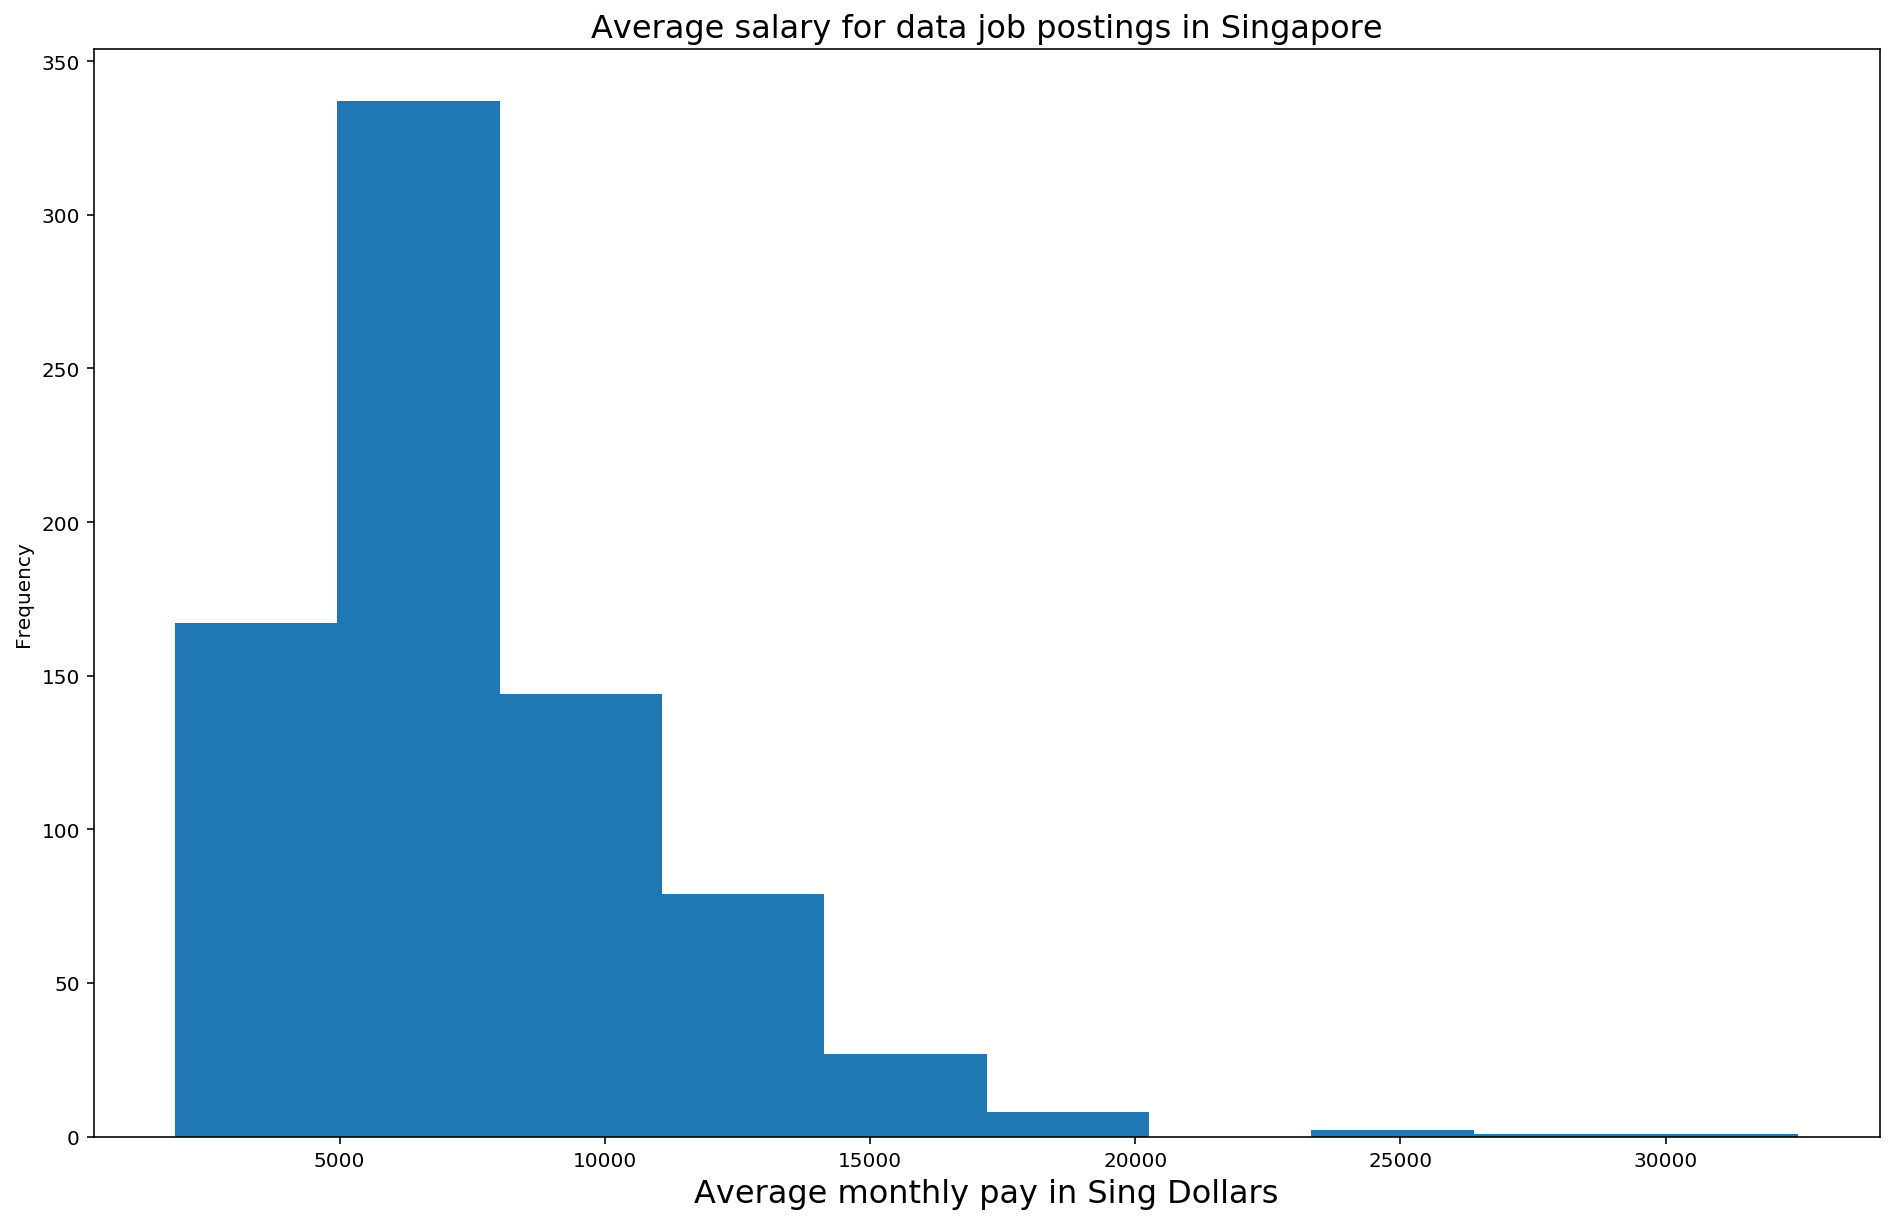

In [29]:
jobs['Salary_Average'].plot(kind='hist', figsize=(16,10))
plt.xlabel("Average monthly pay in Sing Dollars", fontsize=16)
plt.title(
    "Average salary for data job postings in Singapore", fontsize=16
)
plt.show()

In [30]:
jobs[jobs['Salary_Average'] >= 25000]

,Company,Title,Responsibilities,Requirements,Seniority,Employment_Type,Category,Address,Salary_Min,Salary_Max,Salary_Average
486,SIEMENS MOBILITY PTE. LTD.,Lead Solution Architect,Roles & ResponsibilitiesResponsibilities: ...,RequirementsQualifications required for the po...,Professional,Full Time,Engineering,"THE SIEMENS CENTRE, 60 MACPHERSON ROAD 348615",24000.000000,28000.000000,26000.0
501,Company Undisclosed,Chief Financial Officer,Roles & ResponsibilitiesThe Chief Financial Of...,"RequirementsA Bachelor’s degree in Accounting,...",Senior Management,Permanent,Accounting / Auditing / Taxation,Undisclosed,31666.666667,33333.333333,32500.0
871,ASPENTECH PTE. LTD.,"VP, Sales",Roles & ResponsibilitiesAspenTech is a leading...,Requirements Bachelor’s degree (Engineering/Te...,Senior Management,"Permanent, Full Time",Others,"GALAXIS, 1 FUSIONOPOLIS PLACE 138522",23333.333333,33750.000000,28541.7
957,S.W.I.F.T. TERMINAL SERVICES PTE. LTD.,MANAGERIAL / SENIOR MANAGEMENT,Roles & ResponsibilitiesJob Title: Senior Prod...,RequirementsResponsibilities: Your responsibil...,"Senior Management, Manager",Permanent,Banking and Finance,80 ROBINSON ROAD 068898,22916.666667,27500.000000,25208.3


#### There are 4 salary outliers as we can see from above.
It's clear that the web-scrapping again picked up job postings which don't fit the criteria for data related jobs. I'll remove 3 of the outliers as they are not data jobs:
- Row 501, CFO for undisclosed company
- Row 871 VP, Sales for Aspentech
- Row 957 Senior management for Swift Terminal Services

I'll also remove the Siemens job posting as the monthly salary is more than 3 times-standard-deviation-plus-mean:
- Roll 486, Lead Solution Architect for Siemens Mobility

In [31]:
jobs = jobs.drop([486, 501, 871, 957])

#### 1.5 IMPUTING MISSING SALARY FIGURES
We are now ready to impute the missing salary figures

In [32]:
jobs.describe()

,Salary_Min,Salary_Max,Salary_Average
count,762.000000,762.000000,762.000000
mean,5773.024497,9050.697725,7411.861286
std,2526.903643,4033.656367,3195.794841
min,1800.000000,2000.000000,1900.000000
25%,4000.000000,6000.000000,5000.000000
50%,5000.000000,8000.000000,6750.000000
75%,7000.000000,11700.000000,9100.000000
max,15000.000000,25000.000000,18900.000000


#### The salary numbers now look more in line with what we know about the Singapore job market and the salary expectations in the data industry here. There are still some outliers, though no longer as extreme as we saw previously. As such, I would use the median instead to impute the missing salary figures.  

In [33]:
jobs['Salary_Min'] = jobs['Salary_Min'].fillna(5000)
jobs['Salary_Max'] = jobs['Salary_Max'].fillna(8000)
jobs['Salary_Average'] = jobs['Salary_Average'].fillna(6750)

### 2. TEXT PRE-PROCESSING
As expected, the job postings came in different formats. Let's try to standardise them to the extent possible ahead of visualisation and modelling.

#### 2.1 REMOVING REPETITIVE WORDS SCOOPED UP DURING SCRAPPING
The web scrapping repeatedly picked up words like "Roles & Responsibilities" and "PTE. LTD." which won't be useful in the analysis. I'm getting rid of them (ahead of using stopwords in countvectorizer).

In [34]:
jobs['Responsibilities'] = jobs['Responsibilities'].str.replace('Roles & Responsibilities', '')

In [35]:
jobs['Requirements'] = jobs['Requirements'].str.replace('Requirements', '')

In [36]:
jobs['Company'] = jobs['Company'].str.replace('PTE. LTD.', '')
jobs['Company'] = jobs['Company'].str.replace('PTE LTD', '')
jobs['Company'] = jobs['Company'].str.replace('PRIVATE LIMITED', '')
jobs['Company'] = jobs['Company'].str.replace('LIMITED', '')
jobs['Company'] = jobs['Company'].str.replace('PTE.', '')
jobs['Company'] = jobs['Company'].str.replace('LTD.', '')

#### 2.2 'COMPANY' AND ADDRESS COLUMNS
Converting them out of the all-caps format

In [37]:
jobs['Company'] = jobs['Company'].str.title()

In [38]:
jobs['Address'] = jobs['Address'].str.title()

#### 2.3 'TITLE' COLUMN
This is a critical column for the modelling stage, so spending extra time to clean it thoroughly.

In [39]:
jobs['Title'] = jobs['Title'].str.title()

In [40]:
# Find "plural" job titles
jobs[
    (jobs["Title"] == "Data Scientists")
    | (jobs["Title"] == "Data Analysts")
    | (jobs["Title"] == "Data Engineers")
]

,Company,Title,Responsibilities,Requirements,Seniority,Employment_Type,Category,Address,Salary_Min,Salary_Max,Salary_Average
438,Wsh Experts,Data Scientists,Advanced data analytics Organise data and dra...,Minimum 3 years relevant working experience i...,Professional,Full Time,"Design, Engineering, Information Technology, O...",Undisclosed,4000.0,6000.0,5000.0


In [41]:
# Changing job title to Data Scientist instead of "Data Scientists"
jobs.loc[438] = jobs.loc[438].replace({"Data Scientists": "Data Scientist"})

In [42]:
# Next, let's have a look at unusually long job titles
jobs['Title_Length'] = jobs['Title'].apply(len)

In [43]:
jobs[jobs['Title_Length'] > 20]

,Company,Title,Responsibilities,Requirements,Seniority,Employment_Type,Category,Address,Salary_Min,Salary_Max,Salary_Average,Title_Length
0,Hitachi Consulting Singapore,Senior Consultant (Data Scientist),Problem solver with curious mindset with a hi...,Sound knowledge of machine learning concepts....,Senior Executive,"Permanent, Contract",Information Technology,"Plaza 8 @ Cbp, 1 Changi Business Park Crescent...",6000.000000,9000.000000,7500.0,34
2,Traveloka Services,Senior Level Data Scientist,"Job Description As a Data scientist, you will ...",Solid programming skills and understanding o...,Executive,Permanent,Information Technology,Undisclosed,8300.000000,15000.000000,11650.0,27
3,Traveloka Services,Mid - Senior Level Data Scientist,"As a Data scientist, you will be applying mach...",Solid programming skills and understanding o...,Executive,Permanent,Information Technology,Undisclosed,6100.000000,10700.000000,8400.0,33
4,Traveloka Services,Mid Level Data Scientist,"As a Data scientist, you will be applying mach...",Solid programming skills and understanding o...,Executive,Permanent,Information Technology,Undisclosed,4300.000000,7600.000000,5950.0,24
9,Eps Computer Systems,Data Scientist (Project Manager),Project management of development and impleme...,: PhD/Masters/Bachelors (with good honours) i...,Manager,"Permanent, Contract, Full Time",Information Technology,"Spore Business Federation Ctr, 160 Robinson Ro...",6000.000000,9000.000000,7500.0,32
10,Microsec,Senior Data Scientist,"Responsibilities: 1. Developing, enhancing, au...",": At least 5 year of experience in Python, Uni...",Senior Management,"Permanent, Full Time",Telecommunications,Undisclosed,4500.000000,6500.000000,5500.0,21
11,Datarobot Singapore,Applied Data Science Associate,Looking to move into Data Science? Want to lea...,"Main Experience/Training in science, enginee...",Professional,Permanent,Information Technology,80 Robinson Road 068898,7500.000000,12500.000000,10000.0,30
12,Company Undisclosed,Senior Data Scientist,"Applying data mining techniques, doing statis...",Good understanding of Process & Mathematical ...,Senior Executive,"Contract, Full Time","Engineering, Information Technology",Undisclosed,7000.000000,9500.000000,8250.0,21
14,Validus Capital,Senior Data Scientist,Experience with building insights using varie...,Min 4+ years experience doing quantitative an...,Middle Management,"Permanent, Full Time","Risk Management, Banking and Finance","The Arcade, 11 Collyer Quay 049317",5000.000000,8000.000000,6500.0,21
15,Manpower Staffing Services (Singapore),Business Data Scientist,Work closely with the business to identify is...,Minimum of 4-5 years’ experience with the sta...,Executive,"Contract, Full Time",Information Technology,"Guoco Tower, 1 Wallich Street 078881",5000.000000,8500.000000,6750.0,23


#### It looks like a good number of job titles mean the same thing, but are conflated with other terms. Other titles have salary figures mixed in as well. I'll remove them ahead of modelling, and go with the most frequently used terms such as "Senior Data Scientist" instead of its variants.

In [44]:
jobs.loc[0] = jobs.loc[0].replace(
    {"Senior Consultant (Data Scientist)": "Data Scientist"}
)
jobs.loc[2] = jobs.loc[2].replace(
    {"Senior Level Data Scientist": "Senior Data Scientist"}
)
jobs.loc[9] = jobs.loc[9].replace(
    {"Data Scientist (Project Manager)": "Data Scientist"}
)
jobs.loc[15] = jobs.loc[15].replace({"Business Data Scientist": "Data Scientist"})
jobs.loc[17] = jobs.loc[17].replace(
    {
        "Avp, Data Scientist, Analytics & Innovation, Group Legal, Compliance And Secretariat (Wd03653)": "Data Scientist"
    }
)
jobs.loc[21] = jobs.loc[21].replace(
    {
        "Sr Data Scientist (Exp In Ml, Python, R And Bidata Tech Is Must)": "Data Scientist"
    }
)
jobs.loc[33] = jobs.loc[33].replace(
    {"Intelligent Risk Data Scientist Manager / Assistant Manager": "Data Scientist"}
)
jobs.loc[34] = jobs.loc[34].replace({"Data Transformation Scientist": "Data Scientist"})
jobs.loc[36] = jobs.loc[36].replace({"Data Scientist Analyst": "Data Scientist"})
jobs.loc[41] = jobs.loc[41].replace(
    {
        "Assoc, Data Scientist (Bau) Operations Intelligence, Cbg Ops, Technology And Operations (Wd03348)": "Data Scientist"
    }
)
jobs.loc[43] = jobs.loc[43].replace({"Data Scientist (Economist)": "Data Scientist"})
jobs.loc[53] = jobs.loc[53].replace({"Data Engineer (Ref 22998)": "Data Engineer"})
jobs.loc[55] = jobs.loc[55].replace({"Senior Manager, Data Engineer": "Data Engineer"})
jobs.loc[65] = jobs.loc[65].replace(
    {
        "Pi, Enterprise Intelligence (Data Scientist) Senior Manager (Financial Services), Advisory Sg": "Data Scientist"
    }
)
jobs.loc[75] = jobs.loc[75].replace(
    {"Scientist (Data Analytics)": "Scientist (Data Analytics)"}
)
jobs.loc[133] = jobs.loc[133].replace(
    {
        "Senior Research Scientist (1-Year Contract), Living Analytics Research Centre": "Senior Research Scientist"
    }
)
jobs.loc[141] = jobs.loc[141].replace({"Data Engineer / Analyst": "Data Engineer"})
jobs.loc[150] = jobs.loc[150].replace({"Data Science Engineer": "Data Engineer"})
jobs.loc[154] = jobs.loc[154].replace({"Senior Data Engineer": "Senior Data Engineer"})
jobs.loc[158] = jobs.loc[158].replace(
    {"Mct Global Planning Mfg Data Science Engineer": "Data Engineer"}
)
jobs.loc[162] = jobs.loc[162].replace({"Data Science Engineer": "Data Engineer"})
jobs.loc[163] = jobs.loc[163].replace(
    {
        "Research Associate (Data Science) - Eee / Infinitus": "Research Associate (Data Science)"
    }
)
jobs.loc[220] = jobs.loc[220].replace(
    {
        "Hr Data Analyst / Mnc / Central / 5 Days Week / 1 Year Contract": "HR Data Analyst"
    }
)
jobs.loc[222] = jobs.loc[222].replace(
    {
        "Avp, Senior Data Analyst, Middle Office Technology, Technology And Operations - (Wd03337)": "Senior Data Analyst"
    }
)
jobs.loc[294] = jobs.loc[294].replace(
    {
        "Research Engineer (Data Analytics), I2R (A*Star)": "Research Engineer (Data Analytics)"
    }
)
jobs.loc[298] = jobs.loc[298].replace(
    {
        "Research Engineer (Cyber Security&Intelligence), I2R / A*Star": "Research Engineer (Cyber Security&Intelligence)"
    }
)
jobs.loc[299] = jobs.loc[299].replace(
    {
        "Research Engineer (Visual Intelligence), I2R / A*Star": "Research Engineer (Visual Intelligence)"
    }
)
jobs.loc[301] = jobs.loc[301].replace(
    {
        "Research Engineer (Human Language Technologies) /  I2R (A*Star)": "Research Engineer (Human Language Technologies)"
    }
)
jobs.loc[303] = jobs.loc[303].replace(
    {
        "Research Engineer (Cyber Security&Intelligence), I2R / A*Star": "Research Engineer (Cyber Security&Intelligence)"
    }
)
jobs.loc[320] = jobs.loc[320].replace(
    {
        "Research Engineer (Deep Learning 2.0)  /  I2R (A*Star)": "Research Engineer (Deep Learning 2.0)"
    }
)
jobs.loc[464] = jobs.loc[464].replace(
    {
        "Avp, Senior Data Engineer Consultant, Cbg And Big Data Analytics Technology, T&O (1800059H)": "Senior Data Engineer"
    }
)
jobs.loc[514] = jobs.loc[514].replace(
    {
        "Vp, Financial Crime Analytics – Transaction Monitoring, Group Compliance (Wd02882)": "VP Financial Crime Analytics"
    }
)
jobs.loc[540] = jobs.loc[540].replace(
    {
        "Vp, Cap Data Engineer, Middle Office Tech, Technology & Operations (Wd02988)": "Data Engineer"
    }
)
jobs.loc[655] = jobs.loc[655].replace(
    {
        "Senior Manager - Data Governance & Controls (Jd#5029)": "Senior Manager"
    }
)
jobs.loc[672] = jobs.loc[672].replace(
    {"Vp, Data & Digital Strategic Transformation Lead, Improvement Program, T&O (Wd02837)": "Data & Digital Strategic Transformation Lead"}
)
jobs.loc[808] = jobs.loc[808].replace(
    {"Senior Engineer (Deep Learning) (Ref 23007)": "Senior Engineer (Deep Learning)"}
)
jobs.loc[829] = jobs.loc[829].replace(
    {"Data Engineers ( Renewable Contract Roles )": "Data Engineer"}
)
jobs.loc[844] = jobs.loc[844].replace(
    {
        "Splunk Pre-Sales Consultant (5 Days, Orchard, $5000)": "Splunk Pre-Sales Consultant"
    }
)
jobs.loc[886] = jobs.loc[886].replace(
    {
        "Senior Associate, Qa Lead, Middle Office Technology, Technology And Operations (Wd00414)": "Senior Associate"
    }
)
jobs.loc[925] = jobs.loc[925].replace(
    {
        "Business Analyst  /  Central  /  Up To $5000+Aws+Vb  /  Sql  /  Python": "Business Analyst"
    }
)
jobs.loc[933] = jobs.loc[933].replace(
    {
        "It Support Executive [Pioneer  /  5 Days  /  Hardware Support  /  Networking  /  Sap  /  Immediate]": "IT Support Executive"
    }
)
jobs.loc[950] = jobs.loc[950].replace(
    {
        "Procurement Business Intelligence (19001366)": "Procurement Business Intelligence"
    }
)

#### 2.4 'SENIORITY' COLUMN
Again, another column with repetition and unusual entries that ought to be streamlined. I'll simplify to 9 categories:
- Professional         
- Executive            
- Manager              
- Senior Executive      
- Middle Management     
- Senior Management     
- Entry Level           
- Non-executive         
- Junior Executive      

In [45]:
jobs["Seniority"] = jobs["Seniority"].replace(
    {
        "Fresh/entry level": "Entry Level",
        "Professional, Executive": "Professional",
        "Professional, Senior Executive": "Professional",
        "Executive, Senior Executive": "Executive",
        "Manager, Professional": "Manager",
        "Senior Management, Middle Management": "Senior Management",
        "Manager, Senior Executive": "Manager",
        "Manager, Professional, Senior Executive": "Manager",
        "Fresh/entry level, Junior Executive": "Entry Level",
        "Executive, Junior Executive": "Executive",
        "Professional, Non-executive": "Professional",
        "Executive, Junior Executive, Senior Executive": "Executive",
        "Middle Management, Manager": "Middle Management",
        "Professional, Executive, Senior Executive": "Professional",
        "Middle Management, Manager, Professional": "Middle Management",
        "Senior Management, Manager": "Senior Management",
        "Senior Management, Middle Management, Manager, Senior Executive": "Senior Management",
        "Fresh/entry level, Non-executive": "Entry Level",
        "Middle Management, Manager, Senior Executive": "Middle Management",
        "Fresh/entry level, Professional": "Entry Level",
        "Professional, Executive, Junior Executive": "Professional",
        "Non-executive, Junior Executive": "Junior Executive",
        "Fresh/entry level, Professional, Executive, Junior Executive, Senior Executive": "Entry Level",
        "Manager, Executive, Senior Executive": "Manager",
        "Fresh/entry level, Executive, Senior Executive": "Entry Level",
        "Senior Management, Middle Management, Professional": "Senior Management",
        "Manager, Executive": "Manager",
        "Senior Management, Senior Executive": "Senior Management",
        "Fresh/entry level, Junior Executive, Senior Executive": "Entry Level",
        "Middle Management, Professional, Executive, Senior Executive": "Middle Management",
        "Professional, Junior Executive": "Professional",
        "Professional, Executive, Junior Executive, Senior Executive": "Professional",
    }
)

In [46]:
jobs['Seniority'].value_counts()

Professional         262
Executive            157
Manager              127
Senior Executive      73
Middle Management     53
Senior Management     50
Entry Level           36
Non-executive         29
Junior Executive      25
Name: Seniority, dtype: int64

#### 2.5 'EMPLOYMENT TYPE' COLUMN
Given the nature and demands of data jobs, they are most likely to be full time roles with little variation. I'll simplify down to 4 categories for ease of reference: 
- Permanent     
- Contract      
- Internship      
- Temporary       

In [47]:
jobs["Employment_Type"] = jobs["Employment_Type"].replace(
    {
        "Full Time": "Permanent",
        "Permanent, Full Time": "Permanent",
        "Contract, Full Time": "Contract",
        "Permanent, Contract": "Permanent",
        "Permanent, Contract, Full Time": "Permanent",
        "Full Time, Internship": "Internship",
        "Permanent, Contract, Freelance, Full Time": "Permanent",
        "Contract, Internship": "Internship",
        "Part Time, Permanent, Temporary, Freelance, Full Time, Internship": "Temporary",
        "Permanent, Temporary, Contract, Freelance": "Permanent",
    }
)

In [48]:
jobs['Employment_Type'].value_counts()

Permanent     632
Contract      172
Internship      5
Temporary       3
Name: Employment_Type, dtype: int64

#### 2.6 REMOVING PUNCTUATION FROM RESPONSIBILITIES, REQUIREMENTS, ADDRESSS AND CATEGORY COLUMNS

In [49]:
jobs["Responsibilities"] = jobs['Responsibilities'].str.replace('[^\w\s]','')

In [50]:
jobs["Requirements"] = jobs['Requirements'].str.replace('[^\w\s]','')

In [51]:
jobs["Address"] = jobs['Address'].str.replace('[^\w\s]','')

In [52]:
jobs["Category"] = jobs['Category'].str.replace('[^\w\s]','')

#### I'm reasonably satisfied with the preliminary data cleaning, so I'll output it to a new file for visualisation and modelling.

In [53]:
jobs = jobs.drop(columns = 'Title_Length')

In [54]:
#jobs_clean = jobs.to_csv('../data/jobs_clean.csv', index=False)

#### Data Viz for NLP-related projects tend to generate huge files, so I'll do that from a new notebook in 1.2